In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [22]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [23]:
class FTTransformer(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, d_model, dropout):
        super(FTTransformer, self).__init__()
        self.input_dim = input_dim

        # 入力を特徴トークンとして埋め込む
        self.embedding = nn.Linear(input_dim, d_model)
        
        # Transformerエンコーダ層
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout),
            num_layers=num_layers
        )
        
        # 出力層
        self.fc = nn.Linear(d_model, 1)
        
    def forward(self, x):
        # 入力を埋め込み
        # [batch_size, input_dim] -> [batch_size, seq_len=1, d_model]
        x = self.embedding(x).unsqueeze(1)
        
        # 次元を変更 [batch_size, seq_len, d_model] -> [seq_len, batch_size, d_model]
        x = x.permute(1, 0, 2)
        
        # Transformerエンコーダに通す
        x = self.transformer(x)
        
        # 最後のトークンを取得して分類
        # [seq_len, batch_size, d_model] -> [batch_size, d_model]
        x = x.mean(dim=0)  # 平均を取る
        x = self.fc(x)  # 出力層
        return torch.sigmoid(x)


学習データセットの作成

In [24]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

Optunaの設定

In [25]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    num_heads = trial.suggest_categorical('num_heads', [2, 4, 8])
    num_layers = trial.suggest_int('num_layers', 1, 5)
    d_model = trial.suggest_categorical('d_model', [32, 64, 128])
    dropout = trial.suggest_float('dropout', 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める

    # モデル定義
    model = FTTransformer(
        input_dim=X_train.shape[1],
        num_heads=num_heads,
        num_layers=num_layers,
        d_model=d_model,
        dropout=dropout
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val).item()
                predictions = (val_outputs >= 0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [ ]:
device_id =  1  # 使用するGPUのID（0または1）
torch.cuda.se_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-11-29 18:13:15,562] A new study created in memory with name: no-name-e02ac0b5-6a6b-45b4-beef-46b94488f3da
/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:13:55,738] Trial 0 finished with value: 0.09687107653069617 and parameters: {'num_heads': 2, 'num_layers': 3, 'd_model': 128, 'dropout': 0.45, 'learning_rate': 0.0002035110241585683}. Best is trial 0 with value: 0.09687107653069617.


Early stopping at epoch 36
Final MCC: 0.0969


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:14:05,716] Trial 1 finished with value: 0.19330632196469974 and parameters: {'num_heads': 4, 'num_layers': 1, 'd_model': 64, 'dropout': 0.0, 'learning_rate': 0.0001368221928849118}. Best is trial 1 with value: 0.19330632196469974.


Early stopping at epoch 18
Final MCC: 0.1933


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:14:25,901] Trial 2 finished with value: 0.0 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.0, 'learning_rate': 0.0009693085947522154}. Best is trial 1 with value: 0.19330632196469974.


Early stopping at epoch 12
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:14:46,229] Trial 3 finished with value: 0.3710693622969014 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 64, 'dropout': 0.0, 'learning_rate': 0.0004899002858129665}. Best is trial 3 with value: 0.3710693622969014.


Early stopping at epoch 12
Final MCC: 0.3711


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:15:07,355] Trial 4 finished with value: 0.09213462593266854 and parameters: {'num_heads': 8, 'num_layers': 2, 'd_model': 128, 'dropout': 0.15000000000000002, 'learning_rate': 0.00014637486552674834}. Best is trial 3 with value: 0.3710693622969014.


Early stopping at epoch 23
Final MCC: 0.0921


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:15:42,907] Trial 5 finished with value: 0.0 and parameters: {'num_heads': 8, 'num_layers': 5, 'd_model': 32, 'dropout': 0.4, 'learning_rate': 0.0038380865584451847}. Best is trial 3 with value: 0.3710693622969014.


Early stopping at epoch 21
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:15:43,950] Trial 6 pruned. 
[I 2024-11-29 18:15:44,454] Trial 7 pruned. 
[I 2024-11-29 18:16:07,213] Trial 8 finished with value: 0.0 and parameters: {'num_heads': 2, 'num_layers': 4, 'd_model': 128, 'dropout': 0.35000000000000003, 'learning_rate': 0.0035314529336301116}. Best is trial 3 with value: 0.3710693622969014.


Early stopping at epoch 16
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:16:44,298] Trial 9 finished with value: 0.0 and parameters: {'num_heads': 8, 'num_layers': 4, 'd_model': 32, 'dropout': 0.25, 'learning_rate': 0.008654131623196027}. Best is trial 3 with value: 0.3710693622969014.


Early stopping at epoch 26
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:16:45,659] Trial 10 pruned. 
[I 2024-11-29 18:16:46,177] Trial 11 pruned. 
[I 2024-11-29 18:16:46,971] Trial 12 pruned. 
[I 2024-11-29 18:16:47,846] Trial 13 pruned. 
[I 2024-11-29 18:16:49,522] Trial 14 pruned. 
[I 2024-11-29 18:16:50,032] Trial 15 pruned. 
[I 2024-11-29 18:16:51,278] Trial 16 pruned. 
[I 2024-11-29 18:16:51,998] Trial 17 pruned. 
[I 

Early stopping at epoch 20
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:17:54,585] Trial 41 pruned. 
[I 2024-11-29 18:17:56,153] Trial 42 pruned. 
[I 2024-11-29 18:17:57,551] Trial 43 pruned. 
[I 2024-11-29 18:18:23,745] Trial 44 finished with value: 0.0 and parameters: {'num_heads': 4, 'num_layers': 5, 'd_model': 32, 'dropout': 0.35000000000000003, 'learning_rate': 0.0014320823847970984}. Best is trial 3 with value: 0.371

Early stopping at epoch 15
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:18:25,131] Trial 45 pruned. 
[I 2024-11-29 18:18:25,880] Trial 46 pruned. 
[I 2024-11-29 18:19:02,290] Trial 47 finished with value: 0.0 and parameters: {'num_heads': 8, 'num_layers': 5, 'd_model': 32, 'dropout': 0.1, 'learning_rate': 0.00655614005564287}. Best is trial 3 with value: 0.3710693622969014.


Early stopping at epoch 21
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:19:03,116] Trial 48 pruned. 
[I 2024-11-29 18:19:04,201] Trial 49 pruned. 
[I 2024-11-29 18:19:04,770] Trial 50 pruned. 
[I 2024-11-29 18:19:06,647] Trial 51 pruned. 
[I 2024-11-29 18:19:08,252] Trial 52 pruned. 
[I 2024-11-29 18:19:09,658] Trial 53 pruned. 
[I 2024-11-29 18:19:30,307] Trial 54 finished with value: 0.0 and parameters: {'num_heads': 8, 

Early stopping at epoch 12
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:19:31,967] Trial 55 pruned. 
[I 2024-11-29 18:19:33,650] Trial 56 pruned. 
[I 2024-11-29 18:19:35,044] Trial 57 pruned. 
[I 2024-11-29 18:19:36,461] Trial 58 pruned. 
[I 2024-11-29 18:19:37,594] Trial 59 pruned. 
[I 2024-11-29 18:19:38,093] Trial 60 pruned. 
[I 2024-11-29 18:20:17,183] Trial 61 finished with value: 0.0 and parameters: {'num_heads': 2, 

Early stopping at epoch 23
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:20:55,333] Trial 62 finished with value: 0.0 and parameters: {'num_heads': 2, 'num_layers': 4, 'd_model': 128, 'dropout': 0.4, 'learning_rate': 0.00469148558126994}. Best is trial 3 with value: 0.3710693622969014.


Early stopping at epoch 27
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:20:56,972] Trial 63 pruned. 
[I 2024-11-29 18:20:58,141] Trial 64 pruned. 
[I 2024-11-29 18:20:58,911] Trial 65 pruned. 
[I 2024-11-29 18:21:21,336] Trial 66 finished with value: 0.0 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 64, 'dropout': 0.30000000000000004, 'learning_rate': 0.009967890626283104}. Best is trial 3 with value: 0.3710

Early stopping at epoch 15
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:22:00,686] Trial 67 finished with value: 0.0 and parameters: {'num_heads': 2, 'num_layers': 5, 'd_model': 32, 'dropout': 0.4, 'learning_rate': 0.0026877238472183132}. Best is trial 3 with value: 0.3710693622969014.


Early stopping at epoch 23
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:22:01,870] Trial 68 pruned. 
[I 2024-11-29 18:22:02,738] Trial 69 pruned. 
[I 2024-11-29 18:22:04,049] Trial 70 pruned. 
[I 2024-11-29 18:22:05,689] Trial 71 pruned. 
[I 2024-11-29 18:22:34,992] Trial 72 finished with value: 0.0 and parameters: {'num_heads': 8, 'num_layers': 4, 'd_model': 32, 'dropout': 0.2, 'learning_rate': 0.004855170640207065}. Best

Early stopping at epoch 20
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:22:36,621] Trial 73 pruned. 
[I 2024-11-29 18:22:37,739] Trial 74 pruned. 
[I 2024-11-29 18:22:58,126] Trial 75 finished with value: 0.0 and parameters: {'num_heads': 4, 'num_layers': 4, 'd_model': 32, 'dropout': 0.15000000000000002, 'learning_rate': 0.003107989997724954}. Best is trial 3 with value: 0.3710693622969014.


Early stopping at epoch 14
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:22:58,888] Trial 76 pruned. 
[I 2024-11-29 18:22:59,357] Trial 77 pruned. 
[I 2024-11-29 18:23:00,952] Trial 78 pruned. 
[I 2024-11-29 18:23:02,010] Trial 79 pruned. 
[I 2024-11-29 18:23:03,607] Trial 80 pruned. 
[I 2024-11-29 18:23:04,865] Trial 81 pruned. 
[I 2024-11-29 18:23:36,440] Trial 82 finished with value: 0.0 and parameters: {'num_heads': 4, 

Early stopping at epoch 27
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:23:37,515] Trial 83 pruned. 
[I 2024-11-29 18:23:47,650] Trial 84 finished with value: 0.0 and parameters: {'num_heads': 4, 'num_layers': 2, 'd_model': 128, 'dropout': 0.4, 'learning_rate': 0.007058484833336115}. Best is trial 3 with value: 0.3710693622969014.


Early stopping at epoch 11
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:24:04,520] Trial 85 finished with value: 0.0 and parameters: {'num_heads': 4, 'num_layers': 3, 'd_model': 32, 'dropout': 0.2, 'learning_rate': 0.009099032495457394}. Best is trial 3 with value: 0.3710693622969014.


Early stopping at epoch 14
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:24:51,033] Trial 86 finished with value: 0.0 and parameters: {'num_heads': 8, 'num_layers': 4, 'd_model': 128, 'dropout': 0.05, 'learning_rate': 0.005777034133764094}. Best is trial 3 with value: 0.3710693622969014.


Early stopping at epoch 32
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:24:52,130] Trial 87 pruned. 
[I 2024-11-29 18:24:52,874] Trial 88 pruned. 
[I 2024-11-29 18:24:53,380] Trial 89 pruned. 
[I 2024-11-29 18:24:54,897] Trial 90 pruned. 
[I 2024-11-29 18:24:56,472] Trial 91 pruned. 
[I 2024-11-29 18:24:58,113] Trial 92 pruned. 
[I 2024-11-29 18:24:59,664] Trial 93 pruned. 
[I 2024-11-29 18:25:38,630] Trial 94 finished wit

Early stopping at epoch 23
Final MCC: 0.0000


/tmp/ipykernel_187141/3055239567.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  # 範囲を狭める
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-29 18:25:40,359] Trial 95 pruned. 
[I 2024-11-29 18:25:41,857] Trial 96 pruned. 
[I 2024-11-29 18:25:43,222] Trial 97 pruned. 
[I 2024-11-29 18:25:44,925] Trial 98 pruned. 
[I 2024-11-29 18:25:46,034] Trial 99 pruned. 


Best Parameters:  {'num_heads': 4, 'num_layers': 5, 'd_model': 64, 'dropout': 0.0, 'learning_rate': 0.0004899002858129665}
Best Validation F1:  0.3710693622969014


Epoch [1/200], Loss: 0.6147
Epoch [1/200], Train Loss: 0.6147, Val Loss: 0.5775
Epoch [2/200], Loss: 0.5755
Epoch [2/200], Train Loss: 0.5755, Val Loss: 0.6005
Epoch [3/200], Loss: 0.5956
Epoch [3/200], Train Loss: 0.5956, Val Loss: 0.5785
Epoch [4/200], Loss: 0.5910
Epoch [4/200], Train Loss: 0.5910, Val Loss: 0.5711
Epoch [5/200], Loss: 0.5821
Epoch [5/200], Train Loss: 0.5821, Val Loss: 0.5652
Epoch [6/200], Loss: 0.5627
Epoch [6/200], Train Loss: 0.5627, Val Loss: 0.5678
Epoch [7/200], Loss: 0.5667
Epoch [7/200], Train Loss: 0.5667, Val Loss: 0.5686
Epoch [8/200], Loss: 0.5640
Epoch [8/200], Train Loss: 0.5640, Val Loss: 0.5696
Epoch [9/200], Loss: 0.5612
Epoch [9/200], Train Loss: 0.5612, Val Loss: 0.5568
Epoch [10/200], Loss: 0.5603
Epoch [10/200], Train Loss: 0.5603, Val Loss: 0.5809
Epoch [11/200], Loss: 0.5643
Epoch [11/200], Train Loss: 0.5643, Val Loss: 0.5609
Epoch [12/200], Loss: 0.5664
Epoch [12/200], Train Loss: 0.5664, Val Loss: 0.5662
Epoch [13/200], Loss: 0.5643
Epoch

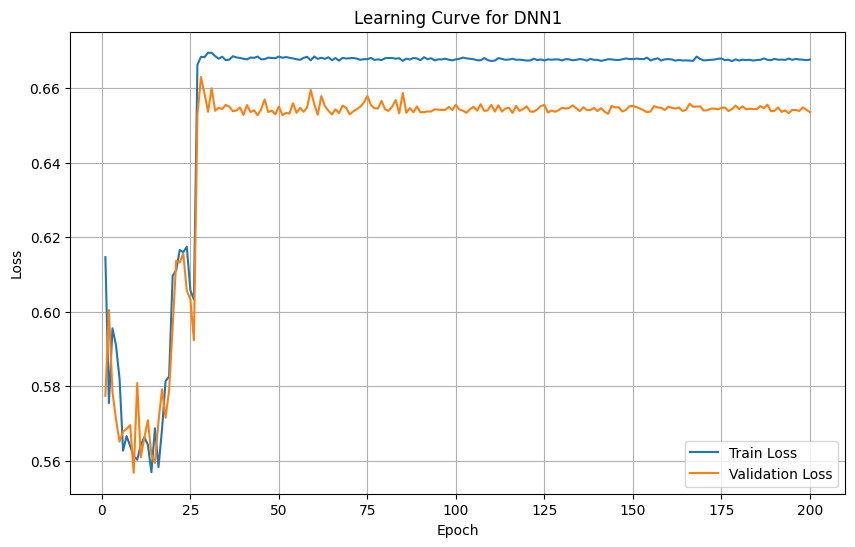

In [27]:
best_params=study.best_params
model = FTTransformer(input_dim=X_train_tensor.shape[1],
                      num_heads=best_params["num_heads"],
                      num_layers=best_params["num_layers"],
                      d_model=best_params["d_model"],
                      dropout=best_params["dropout"]).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"])
criterion = nn.BCELoss()

num_epochs=200
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val)
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 61.39%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


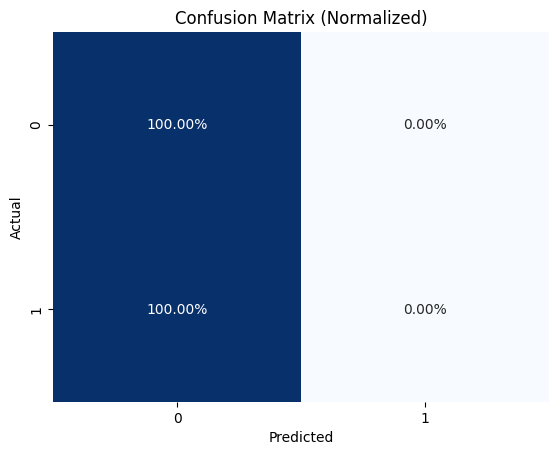

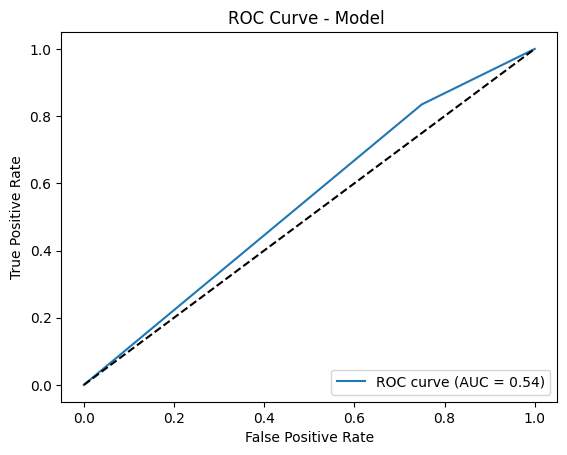

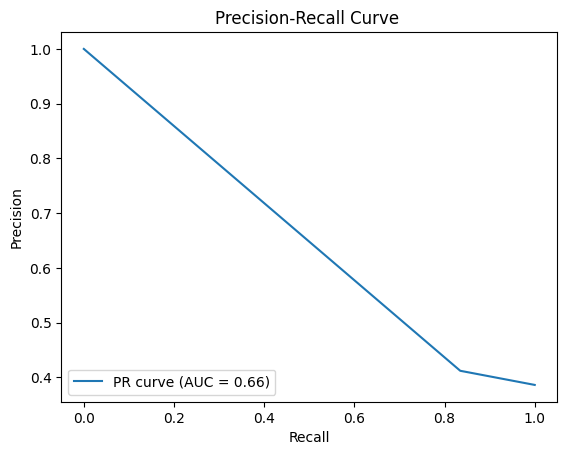

In [28]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >= 0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [29]:
# モデルと構造を保存
torch.save(model, '../../saved_model/FT_tranformer_1.pth')